# Research question 2

#### 2. How often do users visit each other? Does it depend on whether they live in a city or not or on the season of the year?

### Concept

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data, discretize_world, home_locations, lives_in_city


#%load_ext autoreload
#%autoreload 2
#%reload_ext autoreload

### Data

In [2]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"
B_homes = pd.read_pickle("./B_homes.pickle")
G_homes = pd.read_pickle("./G_homes.pickle")
B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


In [3]:
# Make a variable for city and plot colored by city
# Load cities
us_cities = pd.read_pickle('us_cities.pickle')
cities_non_US = pd.read_pickle('cities_non_US.pickle')

In [4]:
%cd "/home/mogan/Desktop"
bk_checkins, bk_edges = load_data("Brightkite")
gw_checkins, gw_edges = load_data("Gowalla")

bk_checkins = bk_checkins.drop(columns=['location_id'], axis=1)
gw_checkins = gw_checkins.drop(columns=['location_id'], axis=1)

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"


/home/mogan/Desktop
/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


In [5]:
#bk_checkins['checkin_time'].to_datetime()

In [6]:
# number of users for analysis
n = 25

## Analysis for non-US cities

In [7]:
# filter for non-us checkins
B_homes = B_homes[B_homes['country'] != 'US']
G_homes = G_homes[G_homes['country'] != 'US']

B_homes = B_homes.rename(columns={'longitude':'home_longitude', 'latitude':'home_latitude'})#.drop(columns=['user'], axis=1)
G_homes = G_homes.rename(columns={'longitude':'home_longitude', 'latitude':'home_latitude'})#.drop(columns=['user'], axis=1)

bk_checkins = bk_checkins.merge(B_homes, left_on='user_id', right_index=True)
gw_checkins = gw_checkins.merge(G_homes, left_on='user_id', right_index=True)

In [8]:
# randomly sample users and take their checkins
bk_user = bk_checkins['user_id'].sample(n, random_state=1)
gw_user = gw_checkins['user_id'].sample(n, random_state=1)
bk_checkins = bk_checkins[bk_checkins['user_id'].isin(bk_user.values)]
gw_checkins = gw_checkins[gw_checkins['user_id'].isin(gw_user.values)]

In [9]:
bk_checkins = bk_checkins.rename(columns={'home_longitude':'home_longitude_A', 'home_latitude':'home_latitude_A'})
gw_checkins = gw_checkins.rename(columns={'home_longitude':'home_longitude_A', 'home_latitude':'home_latitude_A'})

In [10]:
# Make a unique index for every check in, because there is no other unique variable
bk_checkins['check-in'] = bk_checkins.index
gw_checkins['check-in'] = gw_checkins.index

In [11]:
# Merge check-in data with the friend network dataframe
bk_checkins_merged = bk_checkins.merge(bk_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)
gw_checkins_merged = gw_checkins.merge(gw_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)

In [12]:
# Add each friend's B home location to the extended dataframe
bk_checkins_merged = bk_checkins_merged.merge(B_homes, left_on='to_id', right_index=True)#.drop(columns=['home_longitude_y', 'home_latitude_y'], axis=1)
gw_checkins_merged = gw_checkins_merged.merge(G_homes, left_on='to_id', right_index=True)#.drop(columns=['home_longitude_y', 'home_latitude_y'], axis=1)

In [13]:
# Calculate the distance between check-ins and friends home
bk_checkins_merged['distances_to_friend'] = bk_checkins_merged.apply(lambda x: distance((x['latitude'], x['longitude']), (x['home_latitude'], x['home_longitude'])).km, axis = 1)
gw_checkins_merged['distances_to_friend'] = gw_checkins_merged.apply(lambda x: distance((x['latitude'], x['longitude']), (x['home_latitude'], x['home_longitude'])).km, axis = 1)

In [14]:
# Investigate if a check-in was a friends visit or not 
# by grouping by check-in id's and checking if any distance is smaller than r
radius = 25
bk_friend_visited = bk_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()
gw_friend_visited = gw_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()

In [15]:
bk_checkins_merged['visited_friend'] = bk_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)
gw_checkins_merged['visited_friend'] = gw_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)

### How often do friends visit each other?

In [16]:
bk_friend_visited = bk_checkins_merged[bk_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]
gw_friend_visited = gw_checkins_merged[gw_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]


In [17]:
bk_friend_visited['data'] = 'Brightkite'
gw_friend_visited['data'] = 'Gowalla'

bk_gw_friends = bk_friend_visited.append(gw_friend_visited)
#gw_friend_visited.head()

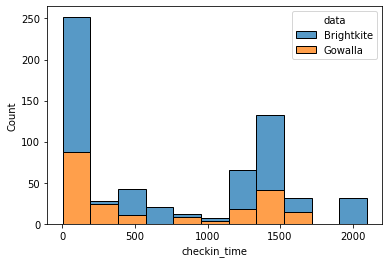

In [18]:
#sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data', multiple="dodge", bins = 30);
sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data',  multiple="stack");

In [57]:
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Group data together
hist_data = [bk_gw_friends['checkin_time'][bk_gw_friends['data'] == 'Brightkite'].values, 
             bk_gw_friends['checkin_time'][bk_gw_friends['data'] == 'Gowalla'].values]

hist_data = [bk_gw_friends['checkin_time'].values]


group_labels = ['All data'] #['Brightkite', 'Gowalla']
colors = ['peru'] #'seagreen', 


# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors=colors)
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=1)
fig.update_layout(
    title="Distribution of friend visits of Non-US citizens",
    xaxis_title="Number of friend visits",
    yaxis_title="Density"
    )

fig.update_layout(barmode='stack')

fig.show()

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots"

html = plot(fig, auto_open=False, output_type='div')
with open("Friend_visit_non_US_distribution.html", 'w') as file:
    file.write(html)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots


In [18]:
# Intermediately save the dataframes
#bk_checkins_merged.to_pickle("B_checkins_merged.pickle")
#gw_checkins_merged.to_pickle("G_checkins_merged.pickle")
#bk_checkins.to_pickle("B_checkins_MS4.pickle")
#gw_checkins.to_pickle("G_checkins_MS4.pickle")

### Does it depend on whether they live in a city or not?

In [36]:
B_homes = B_homes[B_homes.index.isin(bk_checkins['user_id'])]
G_homes = G_homes[G_homes.index.isin(gw_checkins['user_id'])]

In [37]:
# Does user live in a city?
B_merge = B_homes.merge(cities_non_US, left_on = 'country', right_on = 'iso2')
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['home_latitude'], row['home_longitude']), (row['lat'],row['lng']) ).km, axis = 1)
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)

In [38]:
# Does user live in a city?
G_merge = G_homes.merge(cities_non_US, left_on = 'country', right_on = 'iso2')
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['home_latitude'], row['home_longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [39]:
# merge homes and check_ins
bk_friend_city = bk_friend_visited.reset_index().merge(B_homes, left_on = 'user_id', right_index = True)
gw_friend_city = gw_friend_visited.reset_index().merge(G_homes, left_on = 'user_id', right_index = True)
bk_gw_friend_city = bk_friend_city.append(gw_friend_city)
bk_gw_friend_city

,user_id,to_id,checkin_time,data,home_longitude,home_latitude,country,user,lives_urban
0,2894,191,33,Brightkite,138.396103,34.972760,JP,2894,False
1,2894,241,8,Brightkite,138.396103,34.972760,JP,2894,False
2,2894,250,81,Brightkite,138.396103,34.972760,JP,2894,False
3,2894,634,102,Brightkite,138.396103,34.972760,JP,2894,False
4,2894,637,91,Brightkite,138.396103,34.972760,JP,2894,False
...,...,...,...,...,...,...,...,...,...
202,138369,146308,32,Gowalla,11.972109,57.705083,SE,138369,False
203,138369,148910,32,Gowalla,11.972109,57.705083,SE,138369,False
204,165860,89526,21,Gowalla,20.212330,63.832640,SE,165860,True
205,165860,115710,34,Gowalla,20.212330,63.832640,SE,165860,True


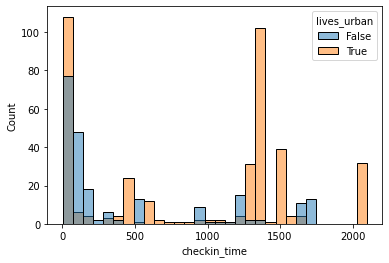

In [40]:
sns.histplot(data = bk_gw_friend_city, x = 'checkin_time', hue = 'lives_urban', bins = 30);

In [60]:
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Group data together
hist_data = [bk_gw_friend_city['checkin_time'][bk_gw_friend_city['lives_urban'] == True].values, 
             bk_gw_friend_city['checkin_time'][bk_gw_friend_city['lives_urban'] == False].values]

group_labels = ['Urban', 'Rural']
colors = ['seagreen', 'peru']


# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors=colors)
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=1)
fig.update_layout(
    title="Distribution of friend visits of Non-US citizens",
    xaxis_title="Number of friend visits",
    yaxis_title="Density",
    legend_title="User lives"
    )

fig.update_layout(barmode='stack')

fig.show()

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots"

html = plot(fig, auto_open=False, output_type='div')
with open("Friend_visit_non_US_urban.html", 'w') as file:
    file.write(html)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots


In [24]:
#g = sns.FacetGrid(bk_gw_friend_city, col="data", hue = 'lives_urban')
#g.map(sns.histplot, 'checkin_time') #,  multiple="dodge"
#g.add_legend();

### Does it depend on the season of the year?

In [25]:
# transform date to datetime
# only take us samples, so seasons don't get confused
# create a variable 'season', do the same plot as before

# Analysis for US cities

### Load data

In [61]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

B_homes = B_homes.rename(columns={'longitude':'home_longitude', 'latitude':'home_latitude'})#.drop(columns=['user'], axis=1)
G_homes = G_homes.rename(columns={'longitude':'home_longitude', 'latitude':'home_latitude'})#.drop(columns=['user'], axis=1)

# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


In [62]:
# Make a variable for city and plot colored by city
# Load cities
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"

us_cities = pd.read_pickle('us_cities.pickle')
cities = pd.read_pickle('cities.pickle')

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


In [63]:
%cd "/home/mogan/Desktop"
bk_checkins_, bk_edges = load_data("Brightkite")
gw_checkins_, gw_edges = load_data("Gowalla")
bk_checkins = bk_checkins_.copy()
gw_checkins = gw_checkins_.copy()

/home/mogan/Desktop


In [64]:
# filter for us checkins
B_homes = B_homes[B_homes['country'] == 'US']
G_homes = G_homes[G_homes['country'] == 'US']

bk_checkins = bk_checkins.merge(B_homes, left_on='user_id', right_index=True)
gw_checkins = gw_checkins.merge(G_homes, left_on='user_id', right_index=True)

In [65]:
# randomly sample users and take their checkins
bk_user = bk_checkins['user_id'].sample(n, random_state=1)
gw_user = gw_checkins['user_id'].sample(n, random_state=1)
bk_checkins = bk_checkins[bk_checkins['user_id'].isin(bk_user.values)]
gw_checkins = gw_checkins[gw_checkins['user_id'].isin(gw_user.values)]

In [66]:
bk_checkins = bk_checkins.rename(columns={'home_longitude':'home_longitude_A', 'home_latitude':'home_latitude_A'})
gw_checkins = gw_checkins.rename(columns={'home_longitude':'home_longitude_A', 'home_latitude':'home_latitude_A'})

In [67]:
# Make a unique index for every check in, because there is no other unique variable
bk_checkins['check-in'] = bk_checkins.index
gw_checkins['check-in'] = gw_checkins.index

In [68]:
# Merge check-in data with the friend network dataframe
bk_checkins_merged = bk_checkins.merge(bk_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)
gw_checkins_merged = gw_checkins.merge(gw_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)

In [69]:
# Add each friend's B home location to the extended dataframe
bk_checkins_merged = bk_checkins_merged.merge(B_homes, left_on='to_id', right_index=True)#.drop(columns=['home_longitude_y', 'home_latitude_y'], axis=1)
gw_checkins_merged = gw_checkins_merged.merge(G_homes, left_on='to_id', right_index=True)#.drop(columns=['home_longitude_y', 'home_latitude_y'], axis=1)

In [70]:
# Calculate the distance between check-ins and friends home
bk_checkins_merged['distances_to_friend'] = bk_checkins_merged.apply(lambda x: distance((x['latitude'], x['longitude']), (x['home_latitude'], x['home_longitude'])).km, axis = 1)
gw_checkins_merged['distances_to_friend'] = gw_checkins_merged.apply(lambda x: distance((x['latitude'], x['longitude']), (x['home_latitude'], x['home_longitude'])).km, axis = 1)

In [71]:
# Investigate if a check-in was a friends visit or not 
# by grouping by check-in id's and checking if any distance is smaller than r
radius = 25
bk_friend_visited = bk_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()
gw_friend_visited = gw_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()

In [72]:
bk_checkins_merged['visited_friend'] = bk_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)
gw_checkins_merged['visited_friend'] = gw_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)

### How often do friends visit each other?

In [73]:
bk_friend_visited = bk_checkins_merged[bk_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]
gw_friend_visited = gw_checkins_merged[gw_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]

In [74]:
bk_friend_visited['data'] = 'Brightkite'
gw_friend_visited['data'] = 'Gowalla'

bk_gw_friends = bk_friend_visited.append(gw_friend_visited)

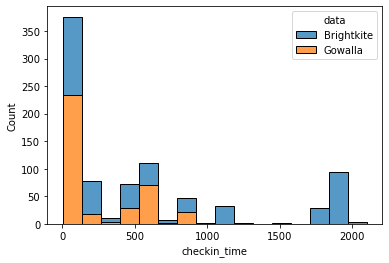

In [75]:
#sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data', multiple="dodge", bins = 30);
sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data',  multiple="stack");

In [76]:
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Group data together
hist_data = [bk_gw_friends['checkin_time'].values]

group_labels = ['All data'] #['Brightkite', 'Gowalla']
colors = ['peru'] #'seagreen', 

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors=colors)
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=1)
fig.update_layout(
    title="Distribution of friend visits of US citizens",
    xaxis_title="Number of friend visits",
    yaxis_title="Density"
    )

fig.update_layout(barmode='stack')

fig.show()

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots"

html = plot(fig, auto_open=False, output_type='div')
with open("Friend_visit_US_distribution.html", 'w') as file:
    file.write(html)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots


In [41]:
# Intermediately save the dataframes
#bk_checkins_merged.to_pickle("B_checkins_merged.pickle")
#gw_checkins_merged.to_pickle("G_checkins_merged.pickle")
#bk_checkins.to_pickle("B_checkins_MS4.pickle")
#gw_checkins.to_pickle("G_checkins_MS4.pickle")

### Does it depend on whether they live in a city or not?

In [77]:
B_homes = B_homes[B_homes.index.isin(bk_checkins['user_id'])]
G_homes = G_homes[G_homes.index.isin(gw_checkins['user_id'])]

In [78]:
# Does user live in a city?
B_merge = B_homes.merge(us_cities, left_on = 'country', right_on = 'iso2')
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['home_latitude'], row['home_longitude']), (row['lat'],row['lng']) ).km, axis = 1)
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)

In [79]:
# Does user live in a city?
G_merge = G_homes.merge(us_cities, left_on = 'country', right_on = 'iso2')
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['home_latitude'], row['home_longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [80]:
# merge homes and check_ins
bk_friend_city = bk_friend_visited.reset_index().merge(B_homes, left_on = 'user_id', right_index = True)
gw_friend_city = gw_friend_visited.reset_index().merge(G_homes, left_on = 'user_id', right_index = True)
bk_gw_friend_city = bk_friend_city.append(gw_friend_city)
bk_gw_friend_city

,user_id,to_id,checkin_time,data,home_longitude,home_latitude,country,user,lives_urban
0,37,0,1177,Brightkite,-105.218189,39.742397,US,37,False
1,37,13,1177,Brightkite,-105.218189,39.742397,US,37,False
2,37,17,136,Brightkite,-105.218189,39.742397,US,37,False
3,37,20,1178,Brightkite,-105.218189,39.742397,US,37,False
4,37,27,136,Brightkite,-105.218189,39.742397,US,37,False
...,...,...,...,...,...,...,...,...,...
374,143454,128475,68,Gowalla,-115.198871,36.110302,US,143454,False
375,143454,132721,68,Gowalla,-115.198871,36.110302,US,143454,False
376,143454,143451,68,Gowalla,-115.198871,36.110302,US,143454,False
377,143454,143452,68,Gowalla,-115.198871,36.110302,US,143454,False


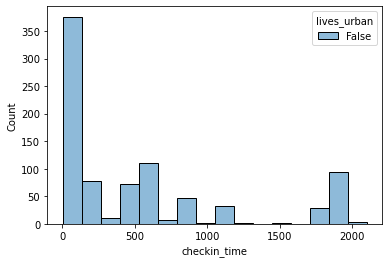

In [81]:
sns.histplot(data = bk_gw_friend_city, x = 'checkin_time', hue = 'lives_urban');

In [48]:
#g = sns.FacetGrid(bk_gw_friend_city, col="data", hue = 'lives_urban')
#g.map(sns.histplot, 'checkin_time') #,  multiple="dodge"
#g.add_legend();

In [82]:
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Group data together
hist_data = [bk_gw_friend_city['checkin_time'][bk_gw_friend_city['lives_urban'] == True].values, 
             bk_gw_friend_city['checkin_time'][bk_gw_friend_city['lives_urban'] == False].values]

group_labels = ['Urban', 'Rural']
colors = ['seagreen', 'peru']


# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors=colors)
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=1)
fig.update_layout(
    title="Distribution of friend visits of US citizens",
    xaxis_title="Number of friend visits",
    yaxis_title="Density",
    legend_title="User lives"
    )

fig.update_layout(barmode='stack')

fig.show()

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots"

html = plot(fig, auto_open=False, output_type='div')
with open("Friend_visit_US_urban.html", 'w') as file:
    file.write(html)

ValueError: min() arg is an empty sequence

### Does it depend on the season of the year?